In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from netcal.metrics import ECE, ACE

from dataloader import get_dataloaders
from models.msdnet import MSDNet
from utils import parse_args
from utils_notebook import *

from collections import OrderedDict, Counter
import random
from typing import Dict

import torchvision.transforms as transforms
import torchvision.datasets as datasets

/home/metod/miniconda3/envs/msdnet/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# a = torch.load('image_net/index.pth')

In [3]:
# import pandas as pd
# import glob
# import os
# import shutil

# # make class folders
# for i in range(1, 1001):
#     try:
#         os.mkdir(f'data/image_net/valid/{i}')
#     except Exception as e:
#         print(i)
#         print(e)

# images = glob.glob("data/image_net/valid/*.JPEG")

# labels = pd.read_csv('data/image_net/valid/labels.txt', header=None)

# # extract number from the image name, e.g. 'data/image_net/valid/ILSVRC2012_val_00013964.JPEG' -> 13964
# images_id = [int(image.split('/')[-1].split('.')[0].split('_')[-1]) for image in images]

# # move images to folder labels
# for id, path in zip(images_id, images):
#     label = labels.iloc[id - 1][0]
#     name = path.split('/')[-1]
#     try:
#         shutil.move(f'data/image_net/valid/{name}', f'data/image_net/valid/{label}/{name}')
#     except Exception as e:
#         print(id)
#         print(e)

In [4]:
# CIFAR-100
ARGS = parse_args()
ARGS.data_root = 'data'
ARGS.data = 'ImageNet'
ARGS.save= f'/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/image_net'
ARGS.arch = 'msdnet'
ARGS.batch_size = 64
ARGS.epochs = 90
ARGS.nBlocks = 5
ARGS.stepmode = 'even'
ARGS.base = 4
ARGS.nChannels = 32
ARGS.growthRate = 16
ARGS.bnFactor = [1, 2, 4, 4]
ARGS.grFactor = [1, 2, 4, 4]
ARGS.j = 16
ARGS.num_classes = 1000
ARGS.step = 4
ARGS.use_valid = True
ARGS.splits = ['train', 'val', 'test']
ARGS.likelihood = 'softmax'
ARGS.nScales = len(ARGS.grFactor)


DATA_PATH = 'data/image_net/valid/'

In [5]:
# load pre-trained model
model = MSDNet(args=ARGS)
MODEL_PATH = f'image_net/msdnet-step=4-block=5.pth.tar'
state = torch.load(MODEL_PATH)
params = OrderedDict()
for params_name, params_val in state['state_dict'].items():
    params[params_name.replace('module.', '')] = params_val
    # state['state_dict'][params_name.replace('module.', '')] = state['state_dict'].pop(params_name)
model.load_state_dict(params)
model = model.cuda()
model.eval()

building network of steps: 
[4, 4, 4, 4, 4] 20
 ********************** Block 1  **********************
|		inScales 4 outScales 4 inChannels 32 outChannels 16		|

|		inScales 4 outScales 4 inChannels 48 outChannels 16		|

|		inScales 4 outScales 4 inChannels 64 outChannels 16		|

|		inScales 4 outScales 4 inChannels 80 outChannels 16		|

 ********************** Block 2  **********************
|		inScales 4 outScales 4 inChannels 96 outChannels 16		|

|		inScales 4 outScales 3 inChannels 112 outChannels 16		|
|		Transition layer inserted! (max), inChannels 128, outChannels 64	|

|		inScales 3 outScales 3 inChannels 64 outChannels 16		|

|		inScales 3 outScales 3 inChannels 80 outChannels 16		|

 ********************** Block 3  **********************
|		inScales 3 outScales 3 inChannels 96 outChannels 16		|

|		inScales 3 outScales 3 inChannels 112 outChannels 16		|

|		inScales 3 outScales 2 inChannels 128 outChannels 16		|
|		Transition layer inserted! (max), inChannels 144, outChannels

MSDNet(
  (blocks): ModuleList(
    (0): Sequential(
      (0): MSDNFirstLayer(
        (layers): ModuleList(
          (0): Sequential(
            (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (1): ConvBasic(
            (net): Sequential(
              (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
              (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
            )
          )
          (2): ConvBasic(
            (net): Sequential(
              (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
              (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True

In [6]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f'nr. of trainable params: {params}')

nr. of trainable params: 23958440


In [7]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

val_set = datasets.ImageFolder(DATA_PATH, transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize
        ]))

In [8]:
val_loader = torch.utils.data.DataLoader(
                val_set,
                batch_size=ARGS.batch_size, shuffle=False,
                num_workers=ARGS.workers, pin_memory=True)

In [9]:
logits = []
targets = []
with torch.no_grad():
    for i, (x, y) in enumerate(val_loader):
        y = y.cuda(device=None)
        x = x.cuda()

        input_var = torch.autograd.Variable(x)
        target_var = torch.autograd.Variable(y)

        output = model(input_var)
        if not isinstance(output, list):
            output = [output]

        logits.append(torch.stack(output))
        targets.append(target_var)

logits = torch.cat(logits, dim=1).cpu()
targets = torch.cat(targets).cpu()

In [10]:
targets[:50]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])

In [15]:
preds[4][:50]

tensor([278, 277, 278, 277, 279, 278, 278, 278, 278, 278, 278, 278, 278, 278,
        277, 278, 277, 277, 278, 278, 280, 278, 278, 278, 277, 278, 280, 104,
        278, 277, 278, 278, 278, 271, 277, 278, 278, 278, 278, 274, 278, 278,
        278, 278, 280, 278, 278, 278, 277, 278])

In [10]:
logits.shape

torch.Size([5, 50000, 1000])

In [11]:
targets.shape

torch.Size([50000])

In [12]:
L = len(logits)
N = 10000

In [13]:
ids = random.sample(range(50000), N)

In [14]:
logits = logits[:, ids, :]

In [15]:
targets = targets[ids]

In [16]:
logits.shape

torch.Size([5, 10000, 1000])

In [13]:
probs = torch.softmax(logits, dim=2)
preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}
acc = [(targets == preds[i]).sum() / len(targets) for i in range(L)]
msp = {i: torch.max(probs, dim=2).values[i, :] for i in range(L)}

torch.Size([50000])

In [18]:
probs_ovr = ovr_likelihood(logits)
preds_ovr = {i: torch.argmax(probs_ovr, dim=2)[i, :] for i in range(L)}
acc_ovr = [(targets == preds_ovr[i]).sum() / len(targets) for i in range(L)]

In [19]:
probs_ovr = ovr_likelihood(logits)
probs_poe_ovr = f_probs_ovr_poe(probs_ovr)
preds_poe_ovr = {i: torch.argmax(probs_poe_ovr, dim=2)[i, :] for i in range(L)}

In [20]:
probs_poe_ovr_break_ties = f_probs_ovr_poe_break_ties(logits, probs_poe_ovr)
preds_poe_ovr_break_ties = {i: torch.argmax(probs_poe_ovr_break_ties, dim=2)[i, :] for i in range(L)}
acc_poe_ovr_break_ties = [(targets == preds_poe_ovr_break_ties[i]).sum() / len(targets) for i in range(L)]

In [21]:
acc

[tensor(0.0014),
 tensor(0.0010),
 tensor(0.0011),
 tensor(0.0013),
 tensor(0.0014)]

In [22]:
preds[0][:50]

tensor([351, 668, 196, 788, 537, 101, 561, 114, 704, 468, 539, 678, 477, 200,
        510, 219, 522, 313, 217, 127, 176, 615, 923, 425, 604, 978, 870, 190,
        861, 159, 854, 463, 476, 977, 174, 588, 480, 628, 882, 887, 627, 537,
        938, 275, 704, 532, 758, 992, 140, 912])

In [23]:
preds[4][:50]

tensor([352, 668, 245, 737, 537, 101, 424, 114, 581, 581, 539, 419, 545, 226,
        510, 201, 522, 315, 217, 127, 353, 754, 923, 425, 604, 801, 870, 190,
        896, 159, 854, 463, 476, 977, 174, 686, 480, 628, 882, 887, 785, 212,
        926, 275, 704, 532, 758, 992,  98, 912])

In [24]:
modal_probs_decreasing(preds, probs, L, N=N)

{0.01: 69.69999999999999,
 0.05: 50.19,
 0.1: 35.949999999999996,
 0.2: 17.8,
 0.5: 1.49}

In [25]:
modal_probs_decreasing(preds_poe_ovr_break_ties, probs_poe_ovr_break_ties, L, N=N)

{0.01: 0.0, 0.05: 0.0, 0.1: 0.0, 0.2: 0.0, 0.5: 0.0}

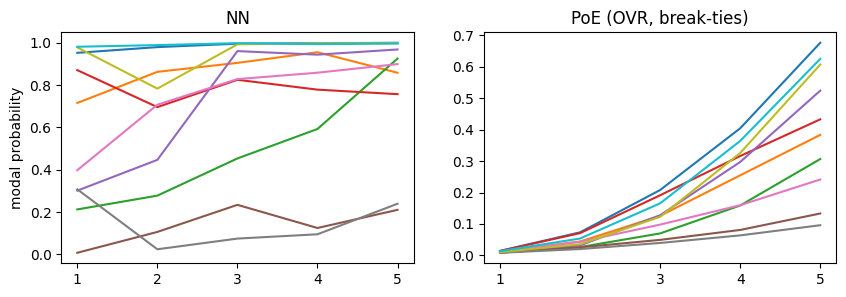

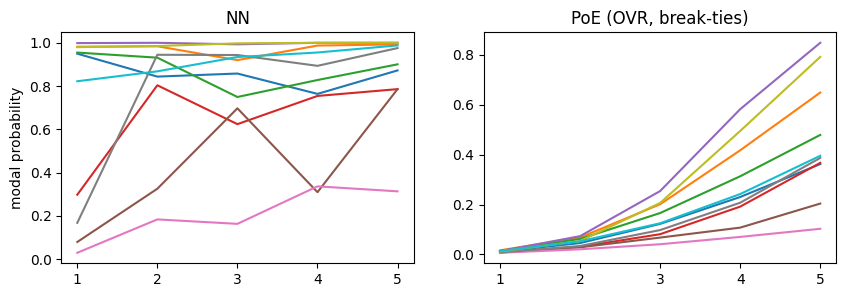

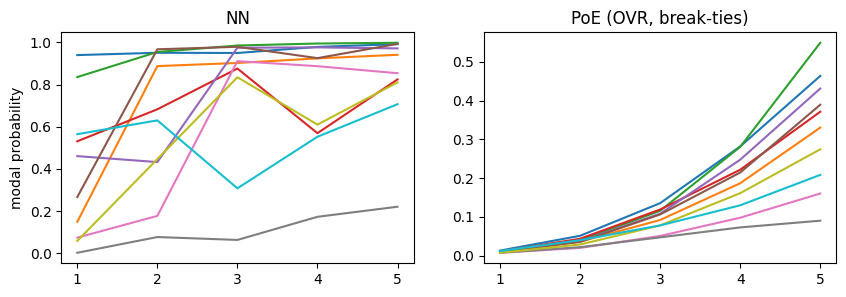

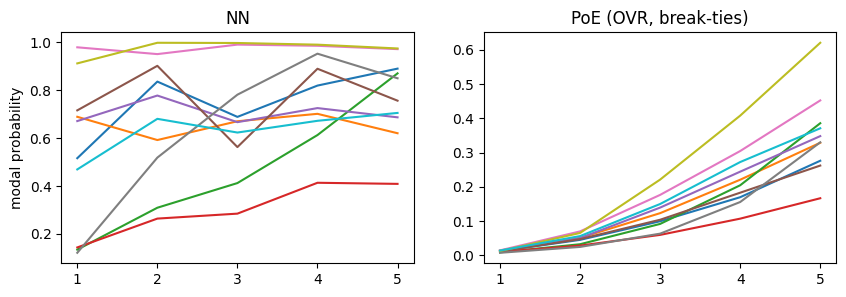

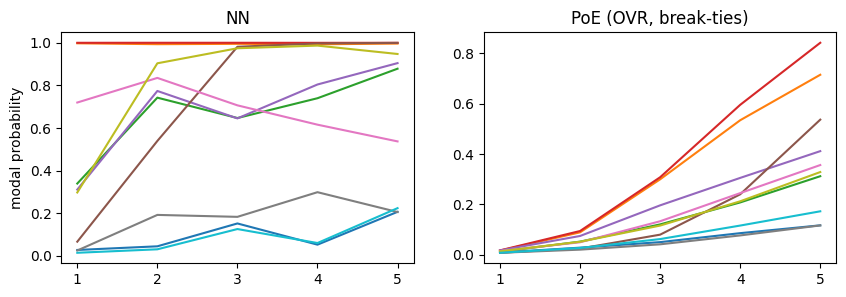

In [26]:
_preds = preds_poe_ovr_break_ties[L - 1]  # modal pred: p(\bar{y})
# _preds = targets  # probability of correct answer: p(y^*)
_probs = probs_poe_ovr_break_ties

for _ in range(5):
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    samples = random.sample(range(N), 10)
    for i in samples:
        probs_i = _probs[:, i, _preds[i]].cpu()
        probs_i_baseline = probs[:, i, preds[L - 1][i]].cpu()
        ax[0].plot(list(range(1, len(probs_i_baseline) + 1)), probs_i_baseline, label=f'{i}');
        ax[1].plot(list(range(1, len(probs_i) + 1)), probs_i, label=f'{i}');
    # plt.savefig('/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/modal_probs.pdf')
    # plt.legend()
    ax[0].set_title('NN')
    ax[1].set_title('PoE (OVR, break-ties)')
    ax[0].set_ylabel('modal probability')
    plt.show()

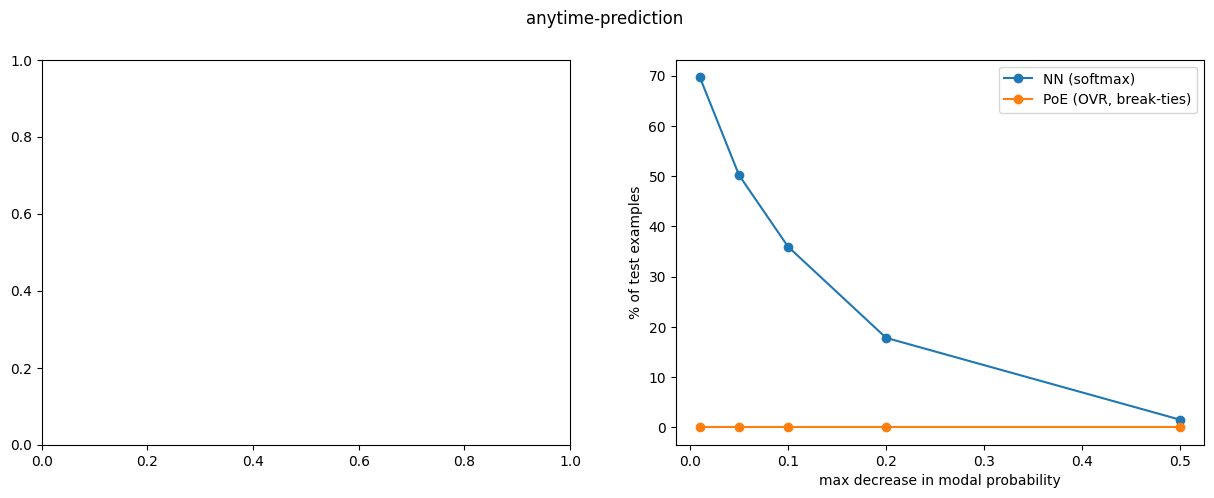

In [29]:
early_exits = [i + 1 for i in range(len(acc))]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

for _preds, _probs, label in [
                            (preds, probs, 'NN (softmax)'), 
                            # (preds_de, probs_de, 'DE (softmax)'), 
                            # (preds_poe, probs_poe, 'PoE (softmax)'),
                            (preds_poe_ovr_break_ties, probs_poe_ovr_break_ties, 'PoE (OVR, break-ties)'),
                            # (preds_poe_ovr, probs_poe_ovr, 'PoE (OVR)'),
                            # (preds_ovr_break_ties, probs_ovr_break_ties, 'NN (OVR, break-ties)'),
                            # (preds_poe_ovr_fallback_ood, probs_poe_ovr_fallback_ood, 'PoE (OVR, fall-back)')
                            ]:
    modal_probs = modal_probs_decreasing(_preds, _probs, L)
    ax[1].plot(modal_probs.keys(), modal_probs.values(), marker='o', label=label)
ax[1].legend()
# ax[1].set_title('anytime-prediction')
ax[1].set_xlabel('max decrease in modal probability')
ax[1].set_ylabel('% of test examples')


plt.suptitle('anytime-prediction')
plt.show()